# Instalações e bibliotecas necessárias

In [ ]:
!pip install transformers -U

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoModelForPreTraining


# BERT

### Treino

In [ ]:
# Carregar o tokenizer e o modelo BERT pré-treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to('cuda')

# Carregar dados e prepará-los
data = pd.read_csv("./repos/HEDOS/HEDOS.csv", engine="python")
filtered_df = data[data['final_label'] != 'Lixo']

data = data[['text','final_label']]
data.head()

# Divisão do dataset em treino e validação
X = list(filtered_df["text"])
y = list(filtered_df["final_label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Tokenização dos dados
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

# Mapeamento de labels para {'not_toxic': 0, 'toxic': 1}
label_mapping = {'not_toxic': 0, 'toxic': 1}
y_train_mapped = [label_mapping[label] for label in y_train]
y_val_mapped = [label_mapping[label] for label in y_val]

# Criação do Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = CustomDataset(X_train_tokenized, y_train_mapped)
val_dataset = CustomDataset(X_val_tokenized, y_val_mapped)

# Função de cálculo de métricas
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Configuração do Trainer
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Iniciar o treinamento
try:
    train_result = trainer.train()
    eval_result = trainer.evaluate()
    results_dict = {
        "training_loss": train_result.training_loss,
        "eval_accuracy": eval_result['eval_accuracy'],
        "eval_f1": eval_result['eval_f1'],
        "train_runtime": train_result.metrics['train_runtime'],
        "train_samples_per_second": train_result.metrics['train_samples_per_second'],
        "total_flos": train_result.metrics['total_flos']
    }
    with open('./results/PEFT/hedos_bert_finetuning_training_results.json', 'w') as f:
        json.dump(results_dict, f)
    print("Resultados salvos com sucesso! hedos_bert_finetuning_training_results")
except Exception as e:
    print(f"Erro durante o treinamento ou avaliação: {e}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Step,Training Loss
10,0.589200
20,0.582900
30,0.526400
40,0.460800
50,0.606100
60,0.517800
70,0.505600
80,0.481400
90,0.524100
100,0.437400


Erro durante o treinamento ou avaliação: name 'json' is not defined


In [ ]:
trainer.evaluate()

{'eval_loss': 0.5243253111839294,
 'eval_accuracy': 0.7834394904458599,
 'eval_precision': 0.7834394904458599,
 'eval_recall': 1.0,
 'eval_f1': 0.8785714285714286,
 'eval_runtime': 16.6576,
 'eval_samples_per_second': 65.976,
 'eval_steps_per_second': 4.142,
 'epoch': 10.0}

In [ ]:
trainer.save_model('./results/PEFT/HEDOS_BERTFineTuningCustomModel')

In [ ]:
# X_train_tokenized.keys()
# print(X_train_tokenized['attention_mask'][0])
# len(X_train),len(X_val)

### Validação

In [ ]:
# Carregar o tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Supondo que você já tenha carregado o modelo assim
model_2 = BertForSequenceClassification.from_pretrained("./results/PEFT/HEDOS_BERTFineTuningCustomModel")
#model_2.to('cuda')

In [ ]:
# Textos de exemplo para avaliação
examples = [
    "Você é incrível!",
    "Eu odeio quando você age assim!",
    "Esse lugar é horrível e as pessoas são terríveis.",
    "Que dia maravilhoso para um passeio no parque!",
    "Você é um idiota e ninguém gosta de você.",
    "Vá para o inferno",
    "Demônio",
    "Puta que pariu, eu amei!",
    "Nordestino nojento"
]

# Tokenizar os exemplos
encoded_inputs = tokenizer(examples, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Garantir que os inputs estejam no dispositivo CUDA
#encoded_inputs = {key: val.to('cuda') for key, val in encoded_inputs.items()}

# Obter previsões
with torch.no_grad():
    outputs = model_2(**encoded_inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    probabilities = F.softmax(outputs.logits, dim=-1)  # Softmax sobre os logits para probabilidades

# Imprimir os resultados
for text, pred, prob in zip(examples, predictions, probabilities):
    prob_t = prob[pred].item() * 100  # Probabilidade da classe prevista
    print(f"Sentença: {text} - Tóxico: {'Sim' if pred.item() == 1 else 'Não'} - Probabilidade: {prob_t:.2f}%")


Sentença: Você é incrível! - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Eu odeio quando você age assim! - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Esse lugar é horrível e as pessoas são terríveis. - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Que dia maravilhoso para um passeio no parque! - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Você é um idiota e ninguém gosta de você. - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Vá para o inferno - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Demônio - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Puta que pariu, eu amei! - Tóxico: Sim - Probabilidade: 80.75%
Sentença: Nordestino nojento - Tóxico: Sim - Probabilidade: 80.75%


# **BERTimbau**

### Treino

In [ ]:
# Carregar o tokenizer e o modelo BERT pré-treinado para classificação de sentenças
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=2).to('cuda')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

# Carregar dados e prepará-los
data = pd.read_csv("./repos/HEDOS/HEDOS.csv", engine="python")
filtered_df = data[data['final_label'] != 'Lixo']

data = data[['text','final_label']]
data.head()

# Divisão do dataset em treino e validação
X = list(filtered_df["text"])
y = list(filtered_df["final_label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Tokenização dos dados
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

# Mapeamento de labels para {'not_toxic': 0, 'toxic': 1}
label_mapping = {'not_toxic': 0, 'toxic': 1}
y_train_mapped = [label_mapping[label] for label in y_train]
y_val_mapped = [label_mapping[label] for label in y_val]

X_train_tokenized.keys()
print(X_train_tokenized['attention_mask'][0])
len(X_train),len(X_val)

# Criação do Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = CustomDataset(X_train_tokenized, y_train_mapped)
val_dataset = CustomDataset(X_val_tokenized, y_val_mapped)

# Função de cálculo de métricas
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Configuração do Trainer
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Iniciar o treinamento
try:
    train_result = trainer.train()
    eval_result = trainer.evaluate()
    results_dict = {
        "training_loss": train_result.training_loss,
        "eval_accuracy": eval_result['eval_accuracy'],
        "eval_f1": eval_result['eval_f1'],
        "train_runtime": train_result.metrics['train_runtime'],
        "train_samples_per_second": train_result.metrics['train_samples_per_second'],
        "total_flos": train_result.metrics['total_flos']
    }
    with open('./results/PEFT/hedos_bertimbau_finetuning_training_results.json', 'w') as f:
        json.dump(results_dict, f)
    print("Resultados salvos com sucesso! hedos_bertimbau_finetuning_training_results")
except Exception as e:
    print(f"Erro durante o treinamento ou avaliação: {e}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Step,Training Loss
10,0.533100
20,0.671900
30,0.489600
40,0.444200
50,0.579100
60,0.552600
70,0.353300
80,0.590700
90,0.480200
100,0.500400


Erro durante o treinamento ou avaliação: name 'json' is not defined


In [ ]:
trainer.evaluate()

{'eval_loss': 1.561152458190918,
 'eval_accuracy': 0.7989080982711556,
 'eval_precision': 0.8587443946188341,
 'eval_recall': 0.8896631823461092,
 'eval_f1': 0.8739304050199658,
 'eval_runtime': 22.4706,
 'eval_samples_per_second': 48.908,
 'eval_steps_per_second': 3.071,
 'epoch': 10.0}

In [ ]:
trainer.save_model('./results/PEFT/HEDOS_BERTimbauFineTuningCustomModel')

### Validação

In [ ]:
# Carregar o tokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Carregar o modelo
model_2 = BertForSequenceClassification.from_pretrained("./results/PEFT/HEDOS_BERTimbauFineTuningCustomModel")
model_2.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Textos de exemplo para avaliação
examples = [
    "Você é incrível!",
    "Eu odeio quando você age assim!",
    "Esse lugar é horrível e as pessoas são terríveis.",
    "Que dia maravilhoso para um passeio no parque!",
    "Você é um idiota e ninguém gosta de você.",
    "Vá para o inferno",
    "Demônio",
    "Puta que pariu, eu amei!",
    "Nordestino nojento"
]

# Tokenizar os exemplos
encoded_inputs = tokenizer(examples, padding=True, truncation=True, max_length=512, return_tensors="pt")


# Garantir que os inputs estejam no dispositivo CUDA
encoded_inputs = {key: val.to('cuda') for key, val in encoded_inputs.items()}

# Obter previsões
with torch.no_grad():
    outputs = model_2(**encoded_inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    probabilities = F.softmax(outputs.logits, dim=-1)  # Softmax sobre os logits para probabilidades

# Imprimir os resultados
for text, pred, prob in zip(examples, predictions, probabilities):
    prob_t = prob[pred].item() * 100  # Probabilidade da classe prevista
    print(f"Sentença: {text} - Tóxico: {'Sim' if pred.item() == 1 else 'Não'} - Probabilidade: {prob_t:.2f}%")


Sentença: Você é incrível! - Tóxico: Sim - Probabilidade: 99.99%
Sentença: Eu odeio quando você age assim! - Tóxico: Não - Probabilidade: 52.36%
Sentença: Esse lugar é horrível e as pessoas são terríveis. - Tóxico: Sim - Probabilidade: 99.99%
Sentença: Que dia maravilhoso para um passeio no parque! - Tóxico: Não - Probabilidade: 99.99%
Sentença: Você é um idiota e ninguém gosta de você. - Tóxico: Sim - Probabilidade: 99.99%
Sentença: Vá para o inferno - Tóxico: Sim - Probabilidade: 99.99%
Sentença: Demônio - Tóxico: Sim - Probabilidade: 99.99%
Sentença: Puta que pariu, eu amei! - Tóxico: Não - Probabilidade: 99.96%
Sentença: Nordestino nojento - Tóxico: Sim - Probabilidade: 99.99%


### Gráfico

Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_59786/3003653187.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


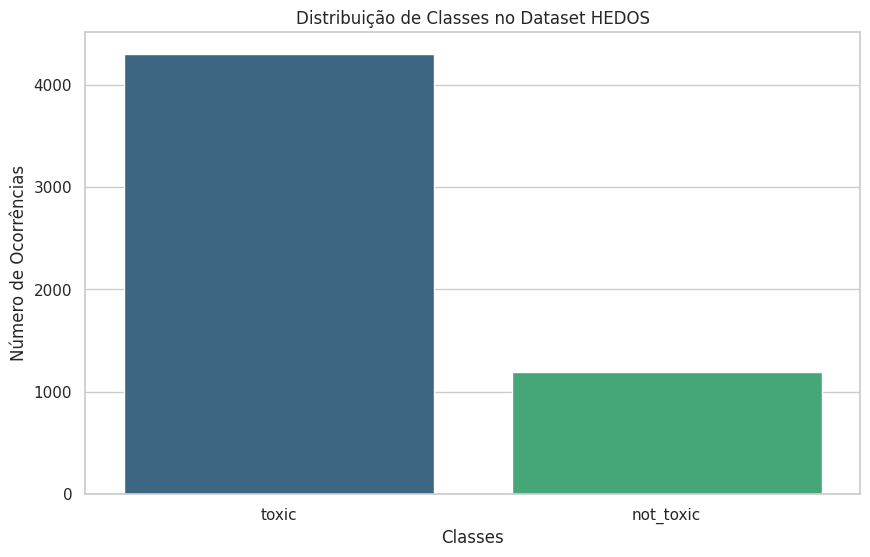

In [ ]:
!pip install pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
data = pd.read_csv("./repos/HEDOS/HEDOS.csv")

# Filtrar dados indesejados
filtered_data = data[data['final_label'] != 'Lixo']

# Contar ocorrências de cada classe
class_counts = filtered_data['final_label'].value_counts()

# Configurações para visualização melhorada
sns.set(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Adicionar título e labels
plt.title('Distribuição de Classes no Dataset HEDOS')
plt.xlabel('Classes')
plt.ylabel('Número de Ocorrências')

# Mostrar o gráfico
plt.show()
